In [28]:
import torch
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt 

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
# Read dataset to array
main_folder_path = "./final_project_data/train"

classes = [folder.path for folder in os.scandir(main_folder_path) if folder.is_dir()]
image_array = []
labels = []
for label, c in enumerate(classes):
    print(f"Processing folder: {c}")
    images = [f.name for f in os.scandir(c) if f.is_file()]
    
    for image in images:
        image_path = os.path.join(c, image)
        with Image.open(image_path) as img:

            img = np.array(img)
            print(img.shape)

            image_array.append(img)
        labels.append(label)
image_array = np.array(image_array)
unique_elements, counts = np.unique(labels, return_counts=True)
num_classes = len(unique_elements)

Processing folder: ./final_project_data/train\n01532829
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84, 3)
(84, 84,

KeyboardInterrupt: 

In [ ]:
print(len(image_array))
#38400 images
# training and validation 5000 each
from sklearn.model_selection import train_test_split

# Assuming you have a list of image arrays called 'image_arrays'
# and corresponding labels in a list called 'labels'
# Split into training (80%) and temporary (20%)
train_set, temp_images, train_labels, temp_labels = train_test_split(
    image_array, labels, test_size=0.2, random_state=42)

test_set, validation_set, test_labels, validation_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42)


38400


In [ ]:
# create dataset class

class ImageNetDataset(Dataset):
    def __init__(self, phase="train", transform=None):
        if phase == "train":
            self.data = train_set
            self.label = train_labels
        elif phase == "test":
            self.data = test_set
            self.label = test_labels
        elif phase == "valid":
            self.data = validation_set
            self.label = validation_labels

        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.label[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
print(len(unique_elements))

64


[486 469 464 473 490 482 481 483 477 477 471 485 471 469 488 485 491 483
 501 478 451 470 484 463 474 490 504 490 494 499 471 481 479 476 480 481
 488 492 483 477 481 477 475 484 473 477 488 476 481 471 471 471 484 485
 488 480 491 482 460 476 480 461 499 478]



(300.0, 700.0)

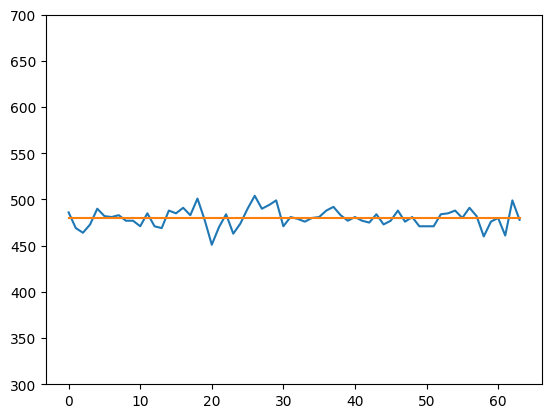

In [ ]:
# sanity check for labels in training
train = ImageNetDataset(phase="train")
unique_elements, counts = np.unique(train.label, return_counts=True)
mean = np.mean(counts)
print(counts)
fig = plt.figure() 
plt.plot(unique_elements, counts)
print()
plt.plot(unique_elements, np.ones(len(counts)) * mean)
plt.ylim((300, 700))

range(0, 100)


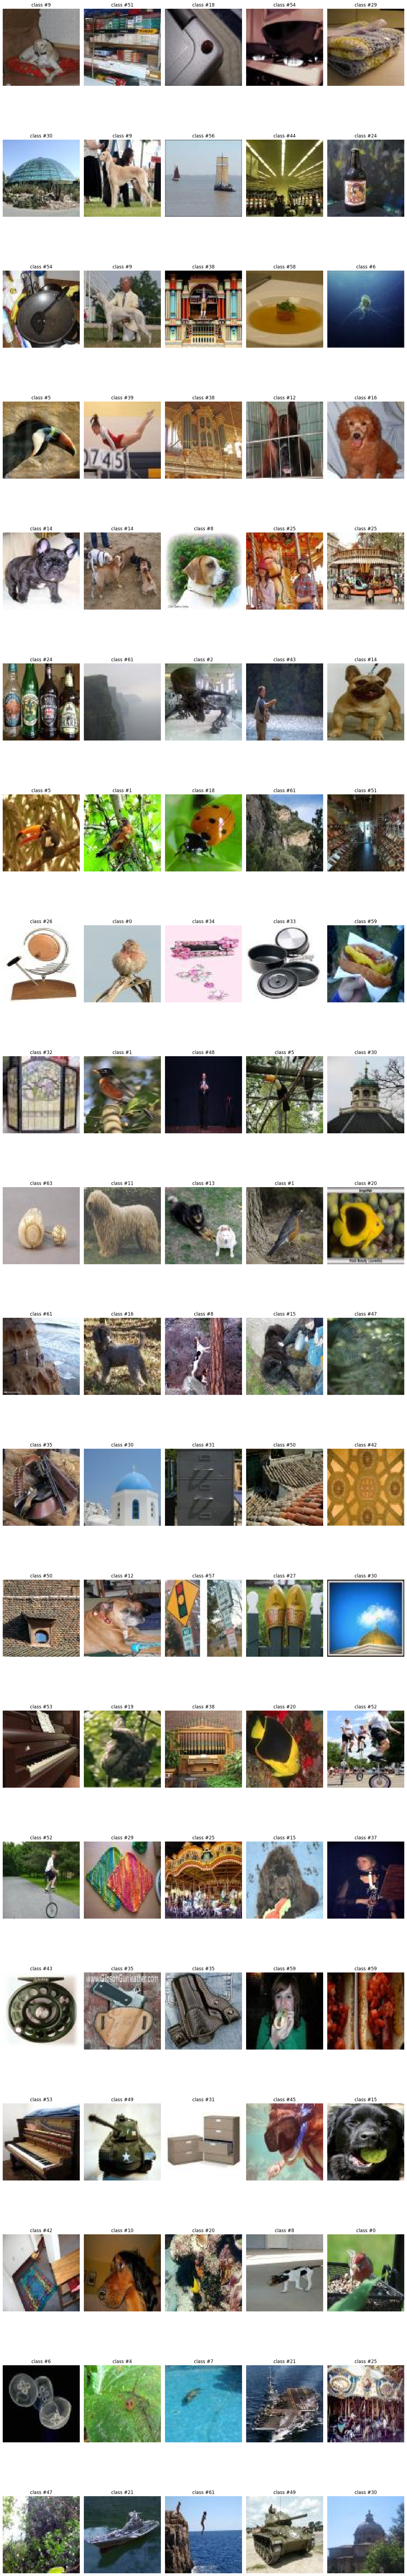

In [ ]:
# SANITY CHECK
train = ImageNetDataset(phase="train")

num_to_show = 100
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False) # randomly pick 5 pictures to show
fig, axes = plt.subplots(20, 5, figsize=(15, 100))
print(range(len(idx)))
axes = axes.flatten()
for i in range(len(idx)):
    image, label = train[idx[i]] 

    ax = axes[i]
    plt.tight_layout()
    ax.set_title('class #{}'.format(label))
    ax.axis('off')
    
    ax.imshow(image)

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = ImageNetDataset("train", transform=data_transform)

test_data = ImageNetDataset("test", transform=data_transform)

valid_data = ImageNetDataset("valid", transform=data_transform)

In [ ]:
image = next(iter(train_data))
print(image[0].shape)

torch.Size([3, 84, 84])


In [ ]:
# DataLoader


train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0) # SHUFFLE = TRUE

test_loader = DataLoader(test_data, batch_size=256, num_workers=0)

valid_loader = DataLoader(valid_data, batch_size=256, num_workers=0)



In [ ]:
print(next(iter(valid_loader))[0].shape)

torch.Size([256, 3, 84, 84])


In [ ]:
### BUILD CNN MODEL BASED ON

class ResNet18(nn.Module):
    def __init__(self, image_shape=None, num_classes=64):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=True)
        self.res_block1 =  nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        )
        self.res_block2 =  nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        )
        self.res_block3 =  nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        )
        self.res_block4 =  nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        

        # residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        x = self.global_avg_pool(x)
        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self.softmax(x)

        return x


In [ ]:

class MarttiResNet16(nn.Module):
    def __init__(self, image_shape=None, num_classes=64):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        self.averagepool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        self.res_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, track_running_stats=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, track_running_stats=True)
        )

        self.res_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, track_running_stats=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, track_running_stats=True),
        )

        self.res_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, track_running_stats=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, track_running_stats=True),
        )

        self.res_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, track_running_stats=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, track_running_stats=True),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.res_block(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)

        x = self.averagepool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
print(model.parameters())

NameError: name 'model' is not defined

In [31]:
# TRAIN THE RESNET MODEL

model = ResNet18()

# evaluation function
def eval(net, data_loader):
    
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda() 
        outs = net(images) 
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader, optim="sgd", weight_decay=0, epoches=10, lr=0.001):
    loss_function = torch.nn.CrossEntropyLoss()
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay (0.5 points)
    if optim == "sgd":
        optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-04)
    elif optim == "adam":
        optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(net.parameters(), lr, momentum=0.9, weight_decay=weight_decay)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
        
    for epoch in range(epoches):
        net.train() 
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            # TODO: rest of the training code
            # your code here, including the forward propagation (0.75 points), 
            
            outputs = net(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            # backward propagation (0.75 points) and calculating the accuracy (0.5 points)
            loss.backward()
            optimizer.step()
            preds = outputs.argmax(dim=1)
            #print(preds, preds.shape)
        
            correct += torch.sum(preds == labels).item()
            num_images += len(images)
            #print(correct, num_images)
            
        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch + 1, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

In [32]:
betterres = MarttiResNet16()
train(betterres, train_loader, valid_loader)

epoch: 1, lr: 0.001000, accuracy: 0.093424, loss: 3.347439, valid accuracy: 0.163281
epoch: 2, lr: 0.001000, accuracy: 0.221549, loss: 3.023815, valid accuracy: 0.243750
epoch: 3, lr: 0.001000, accuracy: 0.299284, loss: 2.681643, valid accuracy: 0.284375
epoch: 4, lr: 0.001000, accuracy: 0.356738, loss: 2.675047, valid accuracy: 0.307813
epoch: 5, lr: 0.001000, accuracy: 0.414355, loss: 2.201750, valid accuracy: 0.340885
epoch: 6, lr: 0.001000, accuracy: 0.478516, loss: 1.993201, valid accuracy: 0.337500
epoch: 7, lr: 0.001000, accuracy: 0.550651, loss: 1.662839, valid accuracy: 0.345573
epoch: 8, lr: 0.001000, accuracy: 0.639681, loss: 1.573348, valid accuracy: 0.323177
epoch: 9, lr: 0.001000, accuracy: 0.742546, loss: 1.220597, valid accuracy: 0.333333
epoch: 10, lr: 0.001000, accuracy: 0.842415, loss: 0.841805, valid accuracy: 0.324479


MarttiResNet16(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (averagepool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=512, out_features=64, bias=True)
  (res_block): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): 

In [ ]:
acc_test = eval(betterres, test_loader).item()
print(acc_test)


0.4619791805744171


In [33]:
torch.save(betterres.state_dict(), 'model.pth')